# Turnover des collaborateurs à l'Assemblée nationale

## Introduction

Cette étude est basée sur les listes de collaborateurs par députés [publiées par l'Assemblée nationale](http://www2.assemblee-nationale.fr/qui/liste-des-collaborateurs-par-depute), collectées et transformées par [Regards Citoyens](https://github.com/regardscitoyens/Collaborateurs-Parlement), puis concaténées et opérationnalisées par nos soins.

Elle cherche à quantifier la rotation de l'emploi, ou _turnover_, des collaborateurs en analysant la durée de leurs contrats de travail, ainsi que les caractéristiques des parlementaires qui les emploient.

Nous exploitons des méthodes issues des statistiques descriptives et inférentielles pour tenter de comprendre s'il existe des profils de collaborations entre les parlementaires et les assistants qu'ils emploient.

## Préparation des données

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, linregress

# Fichier généré quotidiennement par NosDéputés.fr depuis le site de l'AN
csv = pd.read_csv("../data/turnover.csv", encoding='utf-8')

csv["groupes_majoritaires"] = (csv["groupe_sigle"] == "LREM") | (csv["groupe_sigle"] == "MODEM")

# Parsing des dates de contrat, de mandat et de naissance
csv["entree"] = pd.to_datetime(csv["entree"])
csv["sortie"] = pd.to_datetime(csv["sortie"])
csv["mandat_debut"] = pd.to_datetime(csv["mandat_debut"])
csv["mandat_fin"] = pd.to_datetime(csv["mandat_fin"])
csv["date_naissance"] = pd.to_datetime(csv["date_naissance"])

# Calcul des temps de contrat, de mandat et de l'âge
csv["contrat_fini"] = (csv["mandat_fin"] - csv["sortie"]).astype(int) > 10000000000000
csv["duree_mandat"] = csv["mandat_fin"] - csv["mandat_debut"]
csv["duree_mandat"] = csv["duree_mandat"].apply(lambda a: int(a.total_seconds()/60/60/24))
csv["parlementaire_age"] = (max(csv["sortie"]) - csv['date_naissance']).apply(lambda a: int(a.total_seconds()/60/60/24/365))

# Calcul du nombre de contrats courts par parlementaire
csv["contrat_plus_de_2_mois"] = (( (csv["nombredejours"] < 62) & (csv["contrat_fini"] == True)  ) == False) * 1 
csv["contrat_plus_de_4_mois"] = (( (csv["nombredejours"] < 124) & (csv["contrat_fini"] == True) ) == False) * 1
csv["contrat_plus_de_6_mois"] = (( (csv["nombredejours"] < 186) & (csv["contrat_fini"] == True) ) == False) * 1

#Preparation indicateur Rotation de l'emploi
#https://fr.wikipedia.org/wiki/Rotation_de_l%27emploi
date_rotation_un_an = "2017-10-01"
csv["contrat_present_a_date_rotation_un_an"] = (csv["entree"] <= date_rotation_un_an) & (csv["sortie"] > date_rotation_un_an)
csv["contrat_entree_depuis_date_rotation_un_an"] = (csv["entree"] > date_rotation_un_an)
csv["contrat_sortie_depuis_date_rotation_un_an"] = (csv["sortie"] > date_rotation_un_an) & (csv["sortie"] < max(csv["sortie"]))
date_rotation_six_mois = "2018-04-01"
csv["contrat_present_a_date_rotation_six_mois"] = (csv["entree"] <= date_rotation_six_mois) & (csv["sortie"] > date_rotation_six_mois)
csv["contrat_entree_depuis_date_rotation_six_mois"] = (csv["entree"] > date_rotation_six_mois)
csv["contrat_sortie_depuis_date_rotation_six_mois"] = (csv["sortie"] > date_rotation_six_mois) & (csv["sortie"] < max(csv["sortie"]))

csv["contrat_present_a_date_rotation_six_premiers_mois"] = csv["contrat_present_a_date_rotation_un_an"]
csv["contrat_entree_depuis_date_rotation_six_premiers_mois"] = (csv["entree"] > date_rotation_un_an) & (csv["entree"] < date_rotation_six_mois)
csv["contrat_sortie_depuis_date_rotation_six_premiers_mois"] = (csv["sortie"] > date_rotation_un_an) & (csv["sortie"] < date_rotation_six_mois)


# Suppression des contrats inférieurs à 7 jours (problèmes liés aux ministres)
csv = csv[csv["nombredejours"] > 7]

# Suppression des contrats courts de début de législature (fin de contrat de la législature précédente)
csv = csv[(csv["entree"] < "2017-09-01") & (csv["nombredejours"] < 30) == False]
# Supression des députés plus en mandat
csv = csv[csv["mandat_fin"] == max(csv["mandat_fin"])]
csv = csv[csv["mandat_debut"] < date_rotation_un_an]

# Suppression des colonnes inutiles du fichier d'entrée
csv.drop("collaborateurs", 1, inplace=True)

### Contrôle

In [2]:
csv.head()

,parlementaire,nom_parlementaire,prénom_parlementaire,sexe_parlementaire,collaborateur,nom_collaborateur,prénom_collaborateur,sexe_collaborateur,url_nosdeputes_api,url_institution,...,contrat_plus_de_6_mois,contrat_present_a_date_rotation_un_an,contrat_entree_depuis_date_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,contrat_present_a_date_rotation_six_mois,contrat_entree_depuis_date_rotation_six_mois,contrat_sortie_depuis_date_rotation_six_mois,contrat_present_a_date_rotation_six_premiers_mois,contrat_entree_depuis_date_rotation_six_premiers_mois,contrat_sortie_depuis_date_rotation_six_premiers_mois
0,Louis Aliot,Aliot,Louis,H,Mme Rania Messiha,Messiha,Rania,F,https://www.nosdeputes.fr/louis-aliot/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,True,False,False,True,False,False,True,False,False
1,Bertrand Bouyx,Bouyx,Bertrand,H,M. Hugo Guillochin,Guillochin,Hugo,H,https://www.nosdeputes.fr/bertrand-bouyx/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,True,False,False,True,False,False,True,False,False
2,Stéphane Buchou,Buchou,Stéphane,H,Mme Claire Legrand,Legrand,Claire,F,https://www.nosdeputes.fr/stephane-buchou/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,True,False,False,True,False,False,True,False,False
3,Cédric Roussel,Roussel,Cédric,H,Mme Caroline Puisségur-Ripet,Puisségur-Ripet,Caroline,F,https://www.nosdeputes.fr/cedric-roussel/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,False,True,False,True,False,False,False,True,False
4,Isabelle Valentin,Valentin,Isabelle,F,Mme Céline Saby,Saby,Céline,F,https://www.nosdeputes.fr/isabelle-valentin/xml,http://www2.assemblee-nationale.fr/deputes/fic...,...,1,True,False,False,True,False,False,True,False,False


Nombre de collaborateurs :

In [3]:
len(csv['collaborateur'].unique())

2765

Nombre de collaborateurs en cours de contrat :

In [4]:
((csv['contrat_fini']  != True) * 1).sum()

2014

ratio des parlementaires des groupes majoritaires

In [5]:
len(csv[csv["groupes_majoritaires"]]["parlementaire"].unique())/len(csv["parlementaire"].unique())

0.6263345195729537

# Rotation de l'emploi au niveau global

La rotation de l'emploi, ou renouvellement du personnel, est [définie comme suit](https://fr.wikipedia.org/wiki/Rotation_de_l%27emploi) : ((recrutements + fins de contrats) / 2) / nombre d'emplois en début de période.

Celle de l'ensemble des collaborateurs de l'Assemblée sur l'année est de 66.5%. D'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf), ce taux est sensiblement identique au taux national français pour des emplois du tertiaire (64%).

In [6]:
(((csv["contrat_entree_depuis_date_rotation_un_an"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation_un_an"]*1).sum())/2)/((csv["contrat_present_a_date_rotation_un_an"]*1).sum())

0.664572864321608

# Collaborateur : une profession précaire ?

Durée moyenne en mois d'un contrat (contrat en cours inclus) :

In [7]:
csv["nombredejours"].mean()/30.5

9.17015031972235

## Durée des contrats

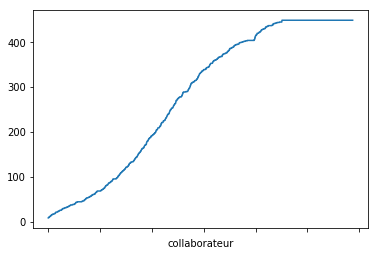

In [8]:
contrats = csv[["nombredejours", "collaborateur"]].reset_index()[["nombredejours", "collaborateur"]]
contrats.index = contrats["collaborateur"]
contrats["nombredejours"].sort_values().plot()

In [9]:
contrats.groupby("nombredejours").count().sort_values(by="collaborateur", ascending=False).head(10)

,collaborateur
nombredejours,
449.0,684
404.0,68
44.0,43
437.0,35
68.0,33
95.0,30
445.0,24
444.0,23
289.0,23


Les seuls paliers notables :

 - début de mandat et contrat en cours (437 j)
 - suppléant suite nomination gouv (392 j)

## Description générale du comportement individuel des députés

### Préparation des données

In [10]:
duree_collaborateurs = csv.groupby(["parlementaire"])[['groupe_sigle']].first().reset_index()
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['sexe_parlementaire']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nom_circo']].first().rename(columns={"nom_circo": "departement"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].median().rename(columns={"nombredejours": "contrat_mediane"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].mean().rename(columns={"nombredejours": "contrat_moyenne"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['collaborateur']].count().rename(columns={"collaborateur": "nb_collaborateurs_total"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['duree_mandat']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_max"}).reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_min"}).reset_index(), on="parlementaire")

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_2_mois']].sum().rename(columns={"contrat_plus_de_2_mois": "nb_contrats_plus_de_2_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_2_mois'] = duree_collaborateurs['nb_contrats_plus_de_2_mois'] / duree_collaborateurs['nb_collaborateurs_total']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_4_mois']].sum().rename(columns={"contrat_plus_de_4_mois": "nb_contrats_plus_de_4_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_4_mois'] = duree_collaborateurs['nb_contrats_plus_de_4_mois'] / duree_collaborateurs['nb_collaborateurs_total']
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_plus_de_6_mois']].sum().rename(columns={"contrat_plus_de_6_mois": "nb_contrats_plus_de_6_mois"}).reset_index(), on="parlementaire")
duree_collaborateurs['ratio_plus_de_6_mois'] = duree_collaborateurs['nb_contrats_plus_de_6_mois'] / duree_collaborateurs['nb_collaborateurs_total']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].count().rename(columns={"nombredejours": "nb_contrat_fini"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs['nb_contrat_fini'].fillna(0, inplace=True)
duree_collaborateurs['ratio_contrat_fini'] = duree_collaborateurs['nb_contrat_fini'] / duree_collaborateurs['nb_collaborateurs_total']

duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].max().rename(columns={"nombredejours": "contrat_fini_max"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv[csv["contrat_fini"] == True].groupby(["parlementaire"])[['nombredejours']].min().rename(columns={"nombredejours": "contrat_fini_min"}).reset_index(), on="parlementaire", how="left")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['ancien_depute']].first().reset_index(), on="parlementaire")
duree_collaborateurs["ratio_contrat_mandat"] = duree_collaborateurs["contrat_mediane"] / duree_collaborateurs["duree_mandat"]
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['nb_mandats']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['parlementaire_age']].first().reset_index(), on="parlementaire")
duree_collaborateurs = duree_collaborateurs.sort_values("ratio_plus_de_2_mois")#sort_values("contrat le plus long")

#Rotation emploi
duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation_un_an', 'contrat_entree_depuis_date_rotation_un_an', 'contrat_sortie_depuis_date_rotation_un_an']].sum().reset_index(), on="parlementaire")
duree_collaborateurs['contrat_present_moyen'] = (duree_collaborateurs['contrat_present_a_date_rotation_un_an'] + duree_collaborateurs['nb_collaborateurs_total'] - duree_collaborateurs['nb_contrat_fini']) / 2
duree_collaborateurs["emploi_rotation_un_an"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation_un_an']+duree_collaborateurs['contrat_sortie_depuis_date_rotation_un_an'])/2)/duree_collaborateurs['contrat_present_moyen']
duree_collaborateurs["emploi_taux_depart_un_an"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation_un_an']/duree_collaborateurs['contrat_present_moyen']
duree_collaborateurs["emploi_taux_arrivee_un_an"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation_un_an']/duree_collaborateurs['contrat_present_moyen']

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation_six_mois', 'contrat_entree_depuis_date_rotation_six_mois', 'contrat_sortie_depuis_date_rotation_six_mois']].sum().reset_index(), on="parlementaire")
duree_collaborateurs["emploi_rotation_six_mois"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation_six_mois']+duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_mois'])/2)/duree_collaborateurs['contrat_present_a_date_rotation_six_mois']
duree_collaborateurs["emploi_taux_depart_six_mois"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_mois']
duree_collaborateurs["emploi_taux_arrivee_six_mois"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation_six_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_mois']

duree_collaborateurs = duree_collaborateurs.merge(csv.groupby(["parlementaire"])[['contrat_present_a_date_rotation_six_premiers_mois', 'contrat_entree_depuis_date_rotation_six_premiers_mois', 'contrat_sortie_depuis_date_rotation_six_premiers_mois']].sum().reset_index(), on="parlementaire")
duree_collaborateurs["emploi_rotation_six_premiers_mois"] =  ((duree_collaborateurs['contrat_entree_depuis_date_rotation_six_premiers_mois']+duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_premiers_mois'])/2)/duree_collaborateurs['contrat_present_a_date_rotation_six_premiers_mois']
duree_collaborateurs["emploi_taux_depart_six_premiers_mois"]   =  duree_collaborateurs['contrat_sortie_depuis_date_rotation_six_premiers_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_premiers_mois']
duree_collaborateurs["emploi_taux_arrivee_six_premiers_mois"] =  duree_collaborateurs['contrat_entree_depuis_date_rotation_six_premiers_mois']/duree_collaborateurs['contrat_present_a_date_rotation_six_premiers_mois']


duree_collaborateurs.to_csv("../data/duree_collaborateur.csv")

### Durée des contrats de collaborateurs

Certains députés ont des collaborateurs fidèles. Le graphique suivant représente le contrat le plus long de chacun des parlementaires. Les _fidèles_ sont représentés par le palier supérieur à droite : la durée de leur contrat est égale à la durée de la législature.

On observe un second palier plus réduit à 300 jours, il représente probablement les fidèles des parlementaires suppléants de députés nommés ministres au sein du gouvernement Philippe 1.

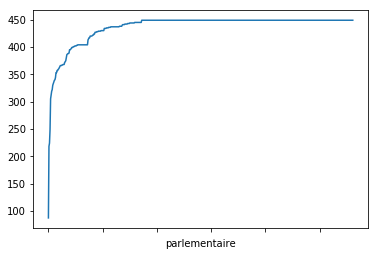

In [11]:
duree_collaborateurs.sort_values("contrat_max").set_index("parlementaire")["contrat_max"].plot()

Le graphique infra représente le contrat le plus court pour chacun des parlementaires.

Rares sont les parlementaires qui ont conservé leur staff tout au long de la 1ère année.

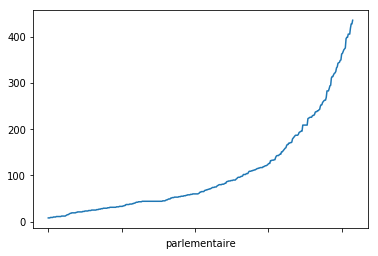

In [12]:
duree_collaborateurs.sort_values("contrat_fini_min").set_index("parlementaire")["contrat_fini_min"].plot()

Plus de la moitié des parlementaires ont déjà mis fin à un contrat dans une durée de moins de 4 mois.

In [13]:
duree_collaborateurs[duree_collaborateurs["contrat_fini_min"] < 122]["parlementaire"].count() * 100 / duree_collaborateurs["parlementaire"].count()

53.02491103202847

# Effet politique ?

## L'influence des groupes politiques

Les durées moyennes de contrat par groupe politique pointent les Non inscrits comme les députés qui gardent le moins longtemps leurs collaborateurs.

In [14]:
duree_collaborateurs[["groupe_sigle", "contrat_mediane"]].groupby("groupe_sigle").mean().sort_values("contrat_mediane")

,contrat_mediane
groupe_sigle,
NI,284.100000
LREM,305.669935
MODEM,314.108696
UAI,329.859375
LR,341.085859
LFI,347.794118
GDR,361.366667
SOC,361.981481


In [15]:
duree_collaborateurs[["groupe_sigle", "emploi_rotation_un_an", "emploi_taux_depart_un_an"]].groupby("groupe_sigle").mean().sort_values("emploi_taux_depart_un_an", ascending=False)

,emploi_rotation_un_an,emploi_taux_depart_un_an
groupe_sigle,,
NI,0.816616,0.667908
LREM,0.670343,0.526727
MODEM,0.623879,0.525500
SOC,0.469195,0.430864
LR,0.550941,0.420361
LFI,0.457937,0.404528
UAI,0.497885,0.390929
GDR,0.533598,0.348889


# Effet de genre ?

# L'influence du sexe

Les durées médianes des contrats de collaborateurs femmes et hommes indiquent que les femmes restent en poste sensiblement plus longtemps, alors que collaborer avec une parlementaire femme mène à des contrats plus courts.

In [16]:
collab_femme_vs_homme = csv.groupby(["sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].median().sort_values("nombredejours")
collab_femme_vs_homme

,nombredejours
sexe_collaborateur,
H,312.0
F,340.0


In [17]:
depute_femme_vs_homme = csv.groupby(["sexe_parlementaire"])[['nombredejours', 'sexe_collaborateur']].median().sort_values("nombredejours")
depute_femme_vs_homme

,nombredejours
sexe_parlementaire,
F,289.0
H,357.0


On observe que seules les parlementaires femmes montrent une préférences de genre envers les hommes pour leurs collaborateurs, mais cela n'influe pas sur la durée des contrats des collaborateurs.

In [18]:
duree_moy_sexe = csv.groupby(["parlementaire", "sexe_parlementaire", "sexe_collaborateur"])[['nombredejours', 'sexe_collaborateur']].mean()
nb_collab_sexe = csv.groupby(["parlementaire", "sexe_collaborateur"])[['collaborateur']].count().rename(columns={'collaborateur': 'nb_collaborateurs'})
stats_sexe = duree_moy_sexe.reset_index().merge(nb_collab_sexe.reset_index(), on=["parlementaire", "sexe_collaborateur"])
stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nombredejours"]].mean().sort_values("nombredejours")

nombredejours
sexe_parlementaire sexe_collaborateur               
F                  H                      277.605351
                   F                      297.804516
H                  H                      306.873235
                   F                      319.659699

In [19]:
nb = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].sum()
moy = stats_sexe.groupby(["sexe_parlementaire", "sexe_collaborateur"])[["nb_collaborateurs"]].mean()["nb_collaborateurs"].rename(columns={"nb_collaborateurs": "nb_collaborateurs_moyen"})

moy.reset_index().merge(nb.reset_index(), on=["sexe_parlementaire", "sexe_collaborateur"]).set_index(["sexe_parlementaire", "sexe_collaborateur"]).rename(columns={0 : 'nb collaborateurs moyen'})


nb collaborateurs moyen  \
sexe_parlementaire sexe_collaborateur                            
F                  F                                  2.784038   
                   H                                  2.887324   
H                  F                                  2.662577   
                   H                                  2.685358   

                                       nb_collaborateurs  
sexe_parlementaire sexe_collaborateur                     
F                  F                                 593  
                   H                                 615  
H                  F                                 868  
                   H                                 862

## Tests statistiques sur les parlementaires

### Préparation des données

In [20]:
# Dichotomisation des variables
duree_tt = duree_collaborateurs
duree_tt["parlementaire_femme"] = (duree_tt["sexe_parlementaire"] == "F") * 1
duree_tt["parlementaire_homme"] = (duree_tt["sexe_parlementaire"] == "H") * 1
duree_tt["parlementaire_has_autre_mandats"] = (duree_tt["nb_mandats"] > 1) * 1
duree_tt["ancien_depute"] = (duree_tt["ancien_depute"]) * 1
for grp in duree_tt["groupe_sigle"].unique():
    duree_tt["groupe_"+grp] = (duree_tt["groupe_sigle"] == grp) * 1

# Inputation des valeurs manquantes
duree_tt["contrat_fini_min"].fillna(150, inplace=True)
duree_tt["contrat_fini_max"].fillna(150, inplace=True)

### Test de significativité des variables dichotomiques

Pour chacune des variables booléennes décrivant les parlementaires (sexe, groupe, etc.) on effectue un test indiquant son effet sur la durée moyenne des contrats de ses collaborateurs.

In [21]:
for i in duree_tt.drop(["contrat_present_a_date_rotation_un_an", "contrat_entree_depuis_date_rotation_un_an", "contrat_sortie_depuis_date_rotation_un_an", "contrat_present_moyen", "emploi_rotation_un_an", "emploi_taux_depart_un_an", "emploi_taux_arrivee_un_an", "contrat_present_a_date_rotation_six_mois", "contrat_entree_depuis_date_rotation_six_mois", "contrat_sortie_depuis_date_rotation_six_mois", "emploi_rotation_six_mois", "emploi_taux_depart_six_mois", "emploi_taux_arrivee_six_mois", "contrat_present_a_date_rotation_six_premiers_mois", "contrat_entree_depuis_date_rotation_six_premiers_mois", "contrat_sortie_depuis_date_rotation_six_premiers_mois", "emploi_rotation_six_premiers_mois", "emploi_taux_depart_six_premiers_mois", "emploi_taux_arrivee_six_premiers_mois", "nb_contrat_fini", "ratio_contrat_fini","contrat_mediane", "contrat_moyenne", "nb_collaborateurs_total", "parlementaire_age", "duree_mandat", "nb_mandats","contrat_max", "contrat_min", "ratio_contrat_mandat", "contrat_fini_max", "contrat_fini_min", "nb_contrats_plus_de_2_mois", "ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois"], 1).columns[4:]:
    cat2 = duree_tt[duree_tt[i] == 0]["contrat_moyenne"]
    cat1 = duree_tt[duree_tt[i] == 1]["contrat_moyenne"]

    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 2.764639, 0.005886

parlementaire_femme : -3.977446, 0.000079

parlementaire_homme : 3.977446, 0.000079

parlementaire_has_autre_mandats non significatif

groupe_MODEM non significatif

groupe_LR : 1.751106, 0.080475

groupe_UAI non significatif

groupe_LREM : -3.000069, 0.002819

groupe_SOC non significatif

groupe_NI non significatif

groupe_LFI non significatif

groupe_GDR : 1.330074, 0.184035



### Tests de régression sur les variables continues

Pour les deux variables continues décrivant les parlementaires (l'âge et le nombre de mandats), on effectue un test de régression qui nous indique son effet sur la durée moyenne de ses contrats.

nb_mandats : non significatif

parlementaire_age : slope:0.016260, intercept:45.078835, 
	rvalue:0.118178, pvalue:0.005029, stderr:0.005029



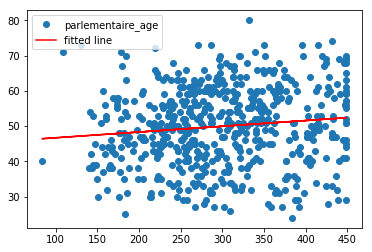

In [22]:
tt = {}
for i in duree_tt.columns[4:].drop(["ancien_depute", "parlementaire_femme", "parlementaire_homme", "groupe_LR", "groupe_LREM", "groupe_MODEM", "groupe_UAI", "groupe_SOC", "groupe_NI", "groupe_LFI", "groupe_GDR", "nb_collaborateurs_total", "contrat_max", "contrat_min", "nb_contrats_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "nb_contrat_fini", "contrat_fini_max", "contrat_fini_min", "ratio_contrat_mandat", "contrat_present_a_date_rotation_un_an", "contrat_entree_depuis_date_rotation_un_an", "contrat_sortie_depuis_date_rotation_un_an", "contrat_present_moyen", "emploi_rotation_un_an", "emploi_taux_depart_un_an", "emploi_taux_arrivee_un_an", "contrat_present_a_date_rotation_six_mois", "contrat_entree_depuis_date_rotation_six_mois", "contrat_sortie_depuis_date_rotation_six_mois", "emploi_rotation_six_mois", "emploi_taux_depart_six_mois", "emploi_taux_arrivee_six_mois", "contrat_present_a_date_rotation_six_premiers_mois", "contrat_entree_depuis_date_rotation_six_premiers_mois", "contrat_sortie_depuis_date_rotation_six_premiers_mois", "emploi_rotation_six_premiers_mois", "emploi_taux_depart_six_premiers_mois", "emploi_taux_arrivee_six_premiers_mois", "contrat_moyenne", "contrat_mediane", "duree_mandat", "ratio_plus_de_2_mois", "ratio_plus_de_4_mois", "ratio_plus_de_6_mois", "ratio_contrat_fini", "parlementaire_has_autre_mandats"], 1):
    tt[i] = linregress(duree_tt["contrat_moyenne"], duree_tt[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(duree_tt["contrat_moyenne"], duree_tt[i], 'o', label=i)
        plt.plot(duree_tt["contrat_moyenne"], tt[i].intercept + tt[i].slope*duree_tt["contrat_moyenne"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

## Tests statistiques sur les collaborateurs

### Préparation des données

In [23]:
tous_collaborateurs = csv.merge(duree_collaborateurs.drop([ 'groupe_sigle', 'sexe_parlementaire', 'duree_mandat', 'nb_mandats', 'parlementaire_age', 'ancien_depute'], 1), on="parlementaire")
tous_collaborateurs["collaborateur_femme"] = (tous_collaborateurs["sexe_collaborateur"] == "F") * 1
tous_collaborateurs["collaborateur_homme"] = (tous_collaborateurs["sexe_collaborateur"] == "H") * 1
tous_collaborateurs.to_csv("../data/turnover_collaborateurs_variables.csv")
tous_collaborateurs = tous_collaborateurs.drop(["entree", "sortie"], 1)

tous_collaborateurs = tous_collaborateurs.drop(['groupe_sigle', 'parti_ratt_financier', 'sites_web','emails', 'adresses', 'autres_mandats', 'anciens_autres_mandats', 'anciens_mandats', 'profession', 'place_en_hemicycle', 'url_an', 'id_an', 'slug', 'url_nosdeputes', "duree_mandat", "departement"], 1)
#tous_collaborateurs.columns[24:]

### Test de significativité des variables dichotomiques

In [24]:
for i in tous_collaborateurs.columns[24:].drop(["contrat_present_a_date_rotation_un_an_x", "contrat_entree_depuis_date_rotation_un_an_x", "contrat_sortie_depuis_date_rotation_un_an_x", "contrat_present_a_date_rotation_six_mois_x", "contrat_entree_depuis_date_rotation_six_mois_x", "contrat_sortie_depuis_date_rotation_six_mois_x", "contrat_present_a_date_rotation_six_premiers_mois_x", "contrat_entree_depuis_date_rotation_six_premiers_mois_x", "contrat_sortie_depuis_date_rotation_six_premiers_mois_x", "contrat_present_a_date_rotation_un_an_y", "contrat_entree_depuis_date_rotation_un_an_y", "contrat_sortie_depuis_date_rotation_un_an_y", "contrat_present_moyen", "emploi_rotation_un_an", "emploi_taux_depart_un_an", "emploi_taux_arrivee_un_an", "contrat_present_a_date_rotation_six_mois_y", "contrat_entree_depuis_date_rotation_six_mois_y", "contrat_sortie_depuis_date_rotation_six_mois_y", "emploi_rotation_six_mois", "emploi_taux_depart_six_mois", "emploi_taux_arrivee_six_mois", "contrat_present_a_date_rotation_six_premiers_mois_y", "contrat_entree_depuis_date_rotation_six_premiers_mois_y", "contrat_sortie_depuis_date_rotation_six_premiers_mois_y", "emploi_rotation_six_premiers_mois", "emploi_taux_depart_six_premiers_mois", "emploi_taux_arrivee_six_premiers_mois", "contrat_fini", "contrat_plus_de_2_mois", "nombredejours","contrat_plus_de_4_mois", "contrat_plus_de_6_mois","parlementaire_age","contrat_mediane","contrat_moyenne","contrat_max","contrat_min","nb_contrats_plus_de_2_mois","ratio_plus_de_2_mois","nb_contrats_plus_de_4_mois","ratio_plus_de_4_mois","nb_contrats_plus_de_6_mois","ratio_plus_de_6_mois","nb_contrat_fini","ratio_contrat_fini","contrat_fini_max","contrat_fini_min","ratio_contrat_mandat"], 1):
    cat2 = tous_collaborateurs[tous_collaborateurs[i] == 0]["nombredejours"]
    cat1 = tous_collaborateurs[tous_collaborateurs[i] == 1]["nombredejours"]
    tt = ttest_ind(cat1, cat2)
    if tt.pvalue < 0.2:
        print("{0} : {1:f}, {2:f}\n".format(i, tt.statistic, tt.pvalue))
    else:
        print(i+" non significatif\n")

ancien_depute : 3.911772, 0.000094

nb_mandats non significatif

groupes_majoritaires : -4.213594, 0.000026

nb_collaborateurs_total non significatif

parlementaire_femme : -5.852047, 0.000000

parlementaire_homme : 5.852047, 0.000000

parlementaire_has_autre_mandats non significatif

groupe_MODEM non significatif

groupe_LR : 3.023322, 0.002522

groupe_UAI non significatif

groupe_LREM : -4.289571, 0.000018

groupe_SOC : 1.550169, 0.121209

groupe_NI non significatif

groupe_LFI : 1.706628, 0.087997

groupe_GDR : 1.827817, 0.067678

collaborateur_femme : 2.581866, 0.009875

collaborateur_homme : -2.581866, 0.009875



### Tests de régression sur la variable continue

parlementaire_age : slope:0.004665, intercept:48.373386, 
	rvalue:0.067706, pvalue:0.000240, stderr:0.000240



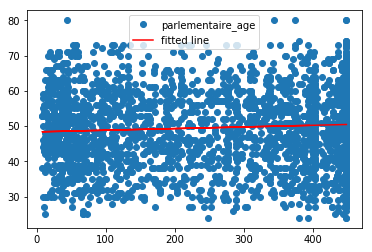

In [25]:
tt = {}
for i in tous_collaborateurs.drop(["emploi_rotation_six_mois", "emploi_taux_depart_six_mois", "emploi_taux_arrivee_six_mois", "contrat_present_a_date_rotation_six_premiers_mois_y", "contrat_entree_depuis_date_rotation_six_premiers_mois_y", "contrat_sortie_depuis_date_rotation_six_premiers_mois_y", "emploi_rotation_six_premiers_mois", "emploi_taux_depart_six_premiers_mois", "emploi_taux_arrivee_six_premiers_mois", "contrat_sortie_depuis_date_rotation_six_mois_y", "contrat_entree_depuis_date_rotation_six_mois_y", "contrat_present_a_date_rotation_six_mois_y", "emploi_taux_arrivee_un_an", "emploi_taux_depart_un_an", "emploi_rotation_un_an", "contrat_present_moyen", "contrat_sortie_depuis_date_rotation_un_an_y", "contrat_entree_depuis_date_rotation_un_an_y", "contrat_present_a_date_rotation_un_an_y", "ratio_contrat_mandat", "contrat_fini_min", "ancien_depute", "nb_mandats", "groupes_majoritaires", "nb_collaborateurs_total", "parlementaire_femme", "parlementaire_homme", "parlementaire_has_autre_mandats", "groupe_MODEM", "groupe_LR", "groupe_LREM", "groupe_UAI", "groupe_SOC", "groupe_NI", "groupe_LFI", "groupe_GDR", "collaborateur_femme", "collaborateur_homme", "contrat_fini", "contrat_plus_de_2_mois", "contrat_plus_de_4_mois", "contrat_plus_de_6_mois", "contrat_present_a_date_rotation_un_an_x", "contrat_entree_depuis_date_rotation_un_an_x", "contrat_sortie_depuis_date_rotation_un_an_x", "contrat_present_a_date_rotation_six_mois_x", "contrat_entree_depuis_date_rotation_six_mois_x", "contrat_sortie_depuis_date_rotation_six_mois_x", "contrat_present_a_date_rotation_six_premiers_mois_x", "contrat_entree_depuis_date_rotation_six_premiers_mois_x", "contrat_sortie_depuis_date_rotation_six_premiers_mois_x", "contrat_max", "contrat_min", "nb_contrats_plus_de_2_mois", "nb_contrats_plus_de_4_mois", "nb_contrats_plus_de_6_mois", "nb_contrat_fini", "ratio_contrat_fini", "contrat_fini_max", "nombredejours", "contrat_moyenne", "contrat_mediane", "ratio_plus_de_2_mois","ratio_plus_de_4_mois","ratio_plus_de_6_mois"], 1).columns[24:]:
    tt[i] = linregress(tous_collaborateurs["nombredejours"], tous_collaborateurs[i])
    #print (tt)
    if tt[i].pvalue < 0.1:
        print("{0} : slope:{1:f}, intercept:{2:f}, \n\trvalue:{3:f}, pvalue:{4:f}, stderr:{4:f}\n".format(i, tt[i].slope, tt[i].intercept, tt[i].rvalue, tt[i].pvalue, tt[i].stderr))
        plt.plot(tous_collaborateurs["nombredejours"], tous_collaborateurs[i], 'o', label=i)
        plt.plot(tous_collaborateurs["nombredejours"], tt[i].intercept + tt[i].slope*tous_collaborateurs["nombredejours"], 'r', label='fitted line')
        plt.legend()
        plt.show()
    else:
        print (i+" : non significatif\n")

Un modèle de regression logit existe et teste la correlation et l'effet des variables entre elles. ([Le code est accessible ici](https://github.com/regardscitoyens/Collaborateurs-Parlement/blob/master/exploitations/script_R_collaborateurs)).

Il révèle que des variables significatives, cinq sont réellement indépendantes :
 - parlementaire_femme / homme
 - groupe_LREM / groupe_NI
 - parlementaire_age

Les autres variables ont une PI Value que nous estimons trop éloignée de 0 pour garantir leur indépendance.


# Effet de la temporalité des fins de contrats

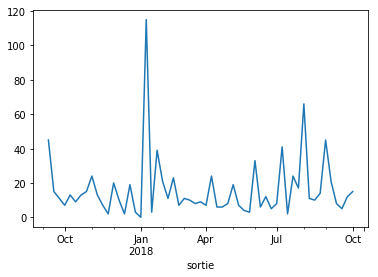

In [26]:
csv.index = csv["sortie"]
csv[csv.index != max(csv["sortie"])].resample('W').count()["collaborateur"].plot()

In [27]:
csv[csv.index != max(csv["sortie"])].resample('D').count()["collaborateur"].sort_values(ascending=False).head(20)

sortie
2018-01-09    105
2017-09-05     39
2018-09-02     38
2018-08-02     34
2018-01-26     33
2018-07-02     29
2018-06-02     20
2018-07-20     19
2018-02-17     18
2018-04-02     17
2018-02-02     15
2018-10-02     15
2018-08-05     13
2017-11-02     12
2018-05-02     11
2017-12-02     11
2018-03-02      8
2017-12-23      8
2018-08-03      8
2017-10-21      8
Name: collaborateur, dtype: int64

## hypothèse : janvier = fin des contrats familiaux

Impossible à détecter de manière systématique. Nécessite un travail d'enquête.

Sous hypothèses :
 
 - lié aux changements autres que contrats familiaux (incompatibilité professionnelle, etc.)
 - emplois familiaux de personnes ne partageant pas le même patronyme
 - non lié au changement de règlementation

In [28]:
janvier = csv[(csv["sortie"] >= '2018-01-01 00:00:00') & (csv["sortie"] <= '2018-01-15 00:00:00')]
janvier[janvier["nom_parlementaire"] == janvier["nom_collaborateur"]]["sortie"]

Series([], Name: sortie, dtype: datetime64[ns])

## hypothèse : LREM et Benalla

Le ratio des départs des collaborateurs provenant d'un groupe majoritaire par rapport à l'ensemble des départ laisse entendre que ces évènements sont liés à l'appartenance à un groupe majoritaire.

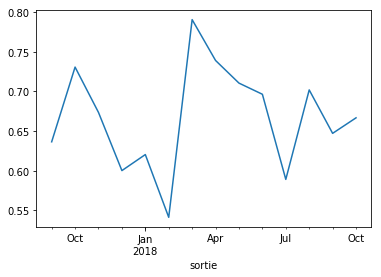

In [29]:
(csv[(csv.index != max(csv["sortie"])) & (csv['groupes_majoritaires'])].resample('M').count()["nom_parlementaire"] / csv[csv.index != max(csv["sortie"])].resample('M').count()["nom_parlementaire"]).plot()


Les deux évènements marquants : Janvier (changement de règlementation) et Juillet (Benalla) sont les évènements qui ont le plus touché les parlementaires non issus de la majorité.

Il n'y a donc pas d'effet Benalla.

# Des effets individuels ?

### Rotation de l'emploi

Pour mesurer les effets du comportement individuel des députés, nous devons nous intéresser à la question des collaborateurs au sein d'une équipe. On peut donc dans ce cas considérer l'équipe d'un député comme une PME.

La rotation moyenne de l'emploi des collaborateurs d'un député est de 53%. Au niveau national, elle est de 58,8% dans les établissements de 1 à 9 salariés d'après une étude de la [DARES de 2011](http://travail-emploi.gouv.fr/IMG/pdf/2012-056.pdf).

Pour limiter les effets de bords liés aux députés avec peu de collaborateurs en octobre 2017 et ayant recruté en cours d'année, le calcul de la rotation de l'emploi est modifiée pour que le ratio ne soit pas basé sur le nombre en début de période mais sur la moyenne sur la période.

La répartition par quartile et la visualisation de la distribution montrent en revanche que 25% des députés ont une rotation d'emploi nettement au dessus de la moyenne nationale (> 100% de taux de rotation).

=> 25% ont renouvelé leur staff de 1 à 3 fois

In [30]:
duree_collaborateurs[duree_collaborateurs["emploi_rotation_un_an"] < 100]["emploi_rotation_un_an"].describe()

count    562.000000
mean       0.621153
std        0.523381
min        0.000000
25%        0.200000
50%        0.500000
75%        1.000000
max        3.000000
Name: emploi_rotation_un_an, dtype: float64

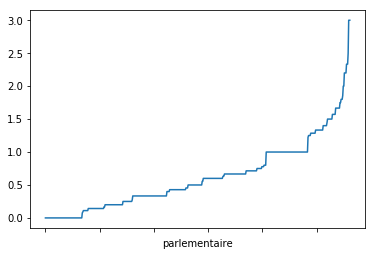

In [31]:
duree_collaborateurs.sort_values("emploi_rotation_un_an").set_index("parlementaire")["emploi_rotation_un_an"].plot()
#duree_collaborateurs["emploi_rotation"].plot()

In [32]:
duree_collaborateurs[(duree_collaborateurs["emploi_rotation_un_an"] < 100) & (duree_collaborateurs["emploi_rotation_un_an"] >= 1)]["parlementaire"].count()

155

## Comportements du dernier quartile

### La rotation d'emploi permet-elle de le comprendre ?

La rotation de l'emploi sur un an permet d'identifier des parlementaires qui ont un fort taux de départs et d'arrivées. Il fait aussi remonter des parlementaires qui n'avaient pas de staff en octobre 2017 (début de la période étudi,ée)


In [33]:
duree_collaborateurs.sort_values(["emploi_rotation_un_an","emploi_rotation_six_mois",'emploi_taux_depart_un_an'], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_rotation_un_an",'contrat_entree_depuis_date_rotation_un_an', 'contrat_sortie_depuis_date_rotation_un_an','contrat_present_moyen', "nb_collaborateurs_total", "nb_contrat_fini","emploi_taux_arrivee_un_an","emploi_taux_depart_un_an"]].head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_rotation_un_an,contrat_entree_depuis_date_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,contrat_present_moyen,nb_collaborateurs_total,nb_contrat_fini,emploi_taux_arrivee_un_an,emploi_taux_depart_un_an
90,Sonia Krimi,LREM,F,Manche,3.000000,7.0,5.0,2.0,9,6.0,3.500000,2.500000
227,Pierre Vatin,LR,H,Oise,3.000000,6.0,3.0,1.5,6,3.0,4.000000,2.000000
63,José Evrard,NI,H,Pas-de-Calais,3.000000,7.0,5.0,2.0,8,5.0,3.500000,2.500000
7,Jérôme Nury,LR,H,Orne,2.500000,7.0,3.0,2.0,7,3.0,3.500000,1.500000
230,Barbara Bessot Ballot,LREM,F,Haute-Saône,2.333333,3.0,4.0,1.5,5,4.0,2.000000,2.666667
131,Michel Vialay,LR,H,Yvelines,2.333333,4.0,3.0,1.5,5,3.0,2.666667,2.000000
536,Jean-Michel Mis,LREM,H,Loire,2.333333,5.0,2.0,1.5,5,2.0,3.333333,1.333333
4,Valérie Rabault,SOC,F,Tarn-et-Garonne,2.200000,6.0,5.0,2.5,8,5.0,2.400000,2.000000
25,Alexandre Freschi,LREM,H,Lot-et-Garonne,2.200000,6.0,5.0,2.5,8,5.0,2.400000,2.000000
45,Anne-France Brunet,LREM,F,Loire-Atlantique,2.200000,6.0,5.0,2.5,9,6.0,2.400000,2.000000


### Et le nombre de contrats terminés ?

Trier les parlementaires par la proportion de contrats clos parmi tous leurs collaborateurs (contrats très courts et parlementaires nouvellement élus exclus)

Incomplet car ceux qui viennent de "perdre" l'intégralité de leur staff remontent par rapport à ceux qui perdent régulièrement leur staff : cas de Aude Bono qui a perdu récemment tout son staff.

In [34]:
duree_collaborateurs.sort_values('ratio_contrat_fini', ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "ratio_contrat_fini", "nb_collaborateurs_total", "nb_contrat_fini"]].head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,ratio_contrat_fini,nb_collaborateurs_total,nb_contrat_fini
341,Aude Bono-Vandorme,LREM,F,Aisne,1.000000,5,5.0
230,Barbara Bessot Ballot,LREM,F,Haute-Saône,0.800000,5,4.0
480,Bérangère Abba,LREM,F,Haute-Marne,0.800000,5,4.0
28,Danièle Hérin,LREM,F,Aude,0.750000,8,6.0
86,Richard Ramos,MODEM,H,Loiret,0.750000,4,3.0
135,Sira Sylla,LREM,F,Seine-Maritime,0.727273,11,8.0
6,Danielle Brulebois,LREM,F,Jura,0.727273,11,8.0
54,Laëtitia Romeiro Dias,LREM,F,Essonne,0.714286,7,5.0
59,Aude Amadou,LREM,F,Loire-Atlantique,0.714286,7,5.0
45,Anne-France Brunet,LREM,F,Loire-Atlantique,0.666667,9,6.0


### Le taux de départ

le nombre de départs sur un an / le nombre moyen de collaborateurs (entre octobre 2017 et 2018)

quand il y a un emploi_taux_depart_six_mois beaucoup plus petit à emploi_taux_depart_six_premiers_mois, c'est que la situation s'est stabilisée dans les derniers mois (lié à une difficulté de recrutement, par exemple)

Les 50 députés ayant un taux de départ les plus élevés ont tous un taux de rotation > 1 (=> font partie du quartile problématique)

In [35]:
duree_collaborateurs.sort_values(['emploi_taux_depart_un_an',"emploi_taux_depart_six_mois"], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_taux_depart_un_an", "emploi_taux_depart_six_mois", "emploi_taux_depart_six_premiers_mois", 'emploi_rotation_un_an', "contrat_sortie_depuis_date_rotation_un_an", 'contrat_present_moyen']].head(10)

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_taux_depart_un_an,emploi_taux_depart_six_mois,emploi_taux_depart_six_premiers_mois,emploi_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,contrat_present_moyen
230,Barbara Bessot Ballot,LREM,F,Haute-Saône,2.666667,1.000000,1.0,2.333333,4.0,1.5
341,Aude Bono-Vandorme,LREM,F,Aisne,2.500000,1.000000,0.0,1.500000,5.0,2.0
90,Sonia Krimi,LREM,F,Manche,2.500000,0.750000,2.0,3.000000,5.0,2.0
63,José Evrard,NI,H,Pas-de-Calais,2.500000,0.500000,3.0,3.000000,5.0,2.0
135,Sira Sylla,LREM,F,Seine-Maritime,2.000000,1.333333,0.8,1.750000,8.0,4.0
4,Valérie Rabault,SOC,F,Tarn-et-Garonne,2.000000,1.000000,1.0,2.200000,5.0,2.5
25,Alexandre Freschi,LREM,H,Lot-et-Garonne,2.000000,1.000000,1.0,2.200000,5.0,2.5
54,Laëtitia Romeiro Dias,LREM,F,Essonne,2.000000,1.000000,1.0,1.800000,5.0,2.5
227,Pierre Vatin,LR,H,Oise,2.000000,0.750000,NaN,3.000000,3.0,1.5
28,Danièle Hérin,LREM,F,Aude,2.000000,0.666667,1.0,1.666667,6.0,3.0


## Hypothèse : une erreur de recrutement en début de législature

À quel point ce taux de rotation est-il lié à des erreurs de recrutement en début de législature ?

Comparons le taux de rotation sur les six derniers mois :

In [36]:
(((csv["contrat_entree_depuis_date_rotation_six_mois"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation_six_mois"]*1).sum())/2)/((csv["contrat_present_a_date_rotation_six_mois"]*1).sum())

0.2401129943502825

sur les six premiers mois :

In [37]:
(((csv["contrat_entree_depuis_date_rotation_six_premiers_mois"]*1).sum()+(csv["contrat_sortie_depuis_date_rotation_six_premiers_mois"]*1).sum())/2)/((csv["contrat_present_a_date_rotation_six_premiers_mois"]*1).sum())

0.3709170854271357

Il y aurait un effet "début de législature" au vu de ce résultat.

Construisons un indicateur permettant d'identifier des éventuels "erreurs de recrutement" dans le dernier quartile :

In [38]:
#Pas de infini ou de division par zero
duree_collaborateurs["emploi_taux_depart_six_mois"] += 0.00000001
duree_collaborateurs["indicateur_recrutement_debut"] = duree_collaborateurs["emploi_taux_depart_six_premiers_mois"] / duree_collaborateurs["emploi_taux_depart_six_mois"]
duree_collaborateurs["erreur_recrutements"] = (duree_collaborateurs["indicateur_recrutement_debut"] > 2)

In [39]:
top50 = duree_collaborateurs.sort_values(['emploi_taux_depart_un_an',"emploi_taux_depart_six_mois"], ascending=False)[["parlementaire", "groupe_sigle", "sexe_parlementaire" ,"departement", "emploi_taux_depart_un_an", 'erreur_recrutements', 'contrat_sortie_depuis_date_rotation_un_an', "emploi_taux_depart_six_mois", "emploi_taux_depart_six_premiers_mois", 'emploi_rotation_un_an', "contrat_sortie_depuis_date_rotation_un_an", 'contrat_present_moyen']].head(50)
top50

,parlementaire,groupe_sigle,sexe_parlementaire,departement,emploi_taux_depart_un_an,erreur_recrutements,contrat_sortie_depuis_date_rotation_un_an,emploi_taux_depart_six_mois,emploi_taux_depart_six_premiers_mois,emploi_rotation_un_an,contrat_sortie_depuis_date_rotation_un_an,contrat_present_moyen
230,Barbara Bessot Ballot,LREM,F,Haute-Saône,2.666667,False,4.0,1.000000e+00,1.000000,2.333333,4.0,1.5
341,Aude Bono-Vandorme,LREM,F,Aisne,2.500000,False,5.0,1.000000e+00,0.000000,1.500000,5.0,2.0
90,Sonia Krimi,LREM,F,Manche,2.500000,True,5.0,7.500000e-01,2.000000,3.000000,5.0,2.0
63,José Evrard,NI,H,Pas-de-Calais,2.500000,True,5.0,5.000000e-01,3.000000,3.000000,5.0,2.0
135,Sira Sylla,LREM,F,Seine-Maritime,2.000000,False,8.0,1.333333e+00,0.800000,1.750000,8.0,4.0
4,Valérie Rabault,SOC,F,Tarn-et-Garonne,2.000000,False,5.0,1.000000e+00,1.000000,2.200000,5.0,2.5
25,Alexandre Freschi,LREM,H,Lot-et-Garonne,2.000000,False,5.0,1.000000e+00,1.000000,2.200000,5.0,2.5
54,Laëtitia Romeiro Dias,LREM,F,Essonne,2.000000,False,5.0,1.000000e+00,1.000000,1.800000,5.0,2.5
227,Pierre Vatin,LR,H,Oise,2.000000,False,3.0,7.500000e-01,NaN,3.000000,3.0,1.5
28,Danièle Hérin,LREM,F,Aude,2.000000,False,6.0,6.666667e-01,1.000000,1.666667,6.0,3.0


30% des parlementaires du dernier quartile ont eu un effet casting : ils ont vu leur taux de départ amélioré lors du 2d semestre :

In [40]:
(duree_collaborateurs[(duree_collaborateurs["emploi_rotation_un_an"] >= 1) & duree_collaborateurs["erreur_recrutements"]].count() / duree_collaborateurs[duree_collaborateurs["emploi_rotation_un_an"] >= 1].count())["parlementaire"]*100

29.677419354838708

In [41]:
#effet erreur de recrutement sur les 50 premiers
top50[top50['erreur_recrutements']]["parlementaire"].count()

13

In [42]:
# données pour Rozenn
duree_collaborateurs.to_csv("../data/turnover_global.csv")

## Conclusions

On observe une rotation moyenne du travail à l'échelle de l'Assemblée comparable au taux moyen français pour les entreprises de petite taille. Malgré cela, certains parlementaires ont un taux sensiblement au-dessus de la moyenne.

Nous avons isolé des parlementaires dont le taux de rotation de l'emploi est le plus haut grâce à des critères descriptifs simples basés sur les temps de contrats des collaborateurs et le nombre de collaborateurs.

Une série de tests statistiques nous a permis de mesurer l'effet de différentes caractéristiques des parlementaires (sexe, âge, groupe politique, etc.) sur la durée médiane des contrats de leurs collaborateurs.

Des profils de managers et d'employés émergent de notre analyse des données collectées depuis le 22 juin 2017. La présence de collaborateurs fidèles, l'influence du sexe, de l'âge ou de l'ancienneté du parlementaire sur la durée des collaborations, ou encore la propension des groupes LREM et NI à se séparer plus rapidement de leurs collaborateurs méritent d'être étudiés plus en détails. Notamment à la lumière d'informations complémentaires sur la teneur des contrats des collaborateurs parlementaires.